In [13]:
from mcmc import mcmc_run, slab_energy

from ase.calculators.eam import EAM
from ase.calculators.lammpsrun import LAMMPS
from ase.io import read

import os
import numpy as np

import sys
sys.path.append("/home/dux/")
from htvs.djangochem.pgmols.utils import surfaces

In [16]:
from time import perf_counter

start = perf_counter()
num_runs = 100

# use LAMMPS
parameters = {
    'pair_style': 'eam',
    'pair_coeff': ['* * Au_u3.eam']
}

potential_file = os.path.join(os.environ["LAMMPS_POTENTIALS"], 'Au_u3.eam')
lammps_calc = LAMMPS(files=[potential_file], keep_tmp_files=False, keep_alive=True, tmp_dir="/home/dux/surface_sampling/tmp_files")
lammps_calc.set(**parameters)

# Au from standard cell
atoms = read('Au_mp-81_conventional_standard.cif')
slab, surface_atoms = surfaces.surface_from_bulk(atoms, [1,1,0], size=[4,4])
slab.write('Au_110_pristine_slab.cif')

slab.calc = lammps_calc
print(f"pristine slab energy is {slab_energy(slab)}")

# calculated energy of desorbed rows (alternating rows removed)
removed_rows = read('Au_110_desorbed_row.cif')
removed_rows.calc = lammps_calc
print(f"desorbed slab energy is {slab_energy(removed_rows)}")

pristine slab energy is -219.6481266447049
desorbed slab energy is -188.6548454008793


In [10]:
# # Au alat from https://periodictable.com/Properties/A/LatticeConstants.html
# Au_alat = 4.0782
element = 'Au'
# slab = initialize_slab(Au_alat, elem=element, miller=(1,1,0), termination=0, orthogonal=False, primitive=False, standardize_bulk=True)

history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=num_runs, temp=1, pot=0, alpha=0.99, slab=slab, calc=lammps_calc, element=element)
stop = perf_counter()
print(f"Time taken = {stop - start} seconds")

/home/dux/miniconda3/envs/mlenv/lib/python3.9/site-packages/catkit/gen/surface.py:334: UserWarning: Your slab has no bulk atoms and may be too thin to identify surface atoms correctly. This may cause surface adsorption site identification to fail.
  warnings.warn(
INFO:Running with num_runs = 200, temp = 1, pot = 0, alpha = 0.995
/home/dux/miniconda3/envs/mlenv/lib/python3.9/site-packages/catkit/gen/adsorption.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/home/dux/miniconda3/envs/mlenv/lib/python3.9/site-packages/catkit/gen/adsorption.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprec

using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7fcd3840bf10>


INFO:In pristine slab, there are a total of 192 sites
/home/dux/miniconda3/envs/mlenv/lib/python3.9/site-packages/ase/calculators/lammpsrun.py:379: UserWarning: semi-periodic ASE cell detected - translation to proper LAMMPS input cell might fail
  warnings.warn(
INFO:running for 192 iterations per run over a total of 200 runs
INFO:In sweep 1 out of 200
INFO:In sweep 2 out of 200
INFO:In sweep 3 out of 200
INFO:In sweep 4 out of 200
INFO:In sweep 5 out of 200
INFO:In sweep 6 out of 200
INFO:In sweep 7 out of 200
INFO:In sweep 8 out of 200
INFO:In sweep 9 out of 200
INFO:In sweep 10 out of 200
INFO:In sweep 11 out of 200
INFO:In sweep 12 out of 200
INFO:In sweep 13 out of 200
INFO:In sweep 14 out of 200
INFO:In sweep 15 out of 200
INFO:In sweep 16 out of 200
INFO:In sweep 17 out of 200
INFO:In sweep 18 out of 200
INFO:In sweep 19 out of 200
INFO:In sweep 20 out of 200
INFO:In sweep 21 out of 200
INFO:In sweep 22 out of 200
INFO:In sweep 23 out of 200
INFO:In sweep 24 out of 200
INFO:In s

Time taken = 454.688245870173 seconds


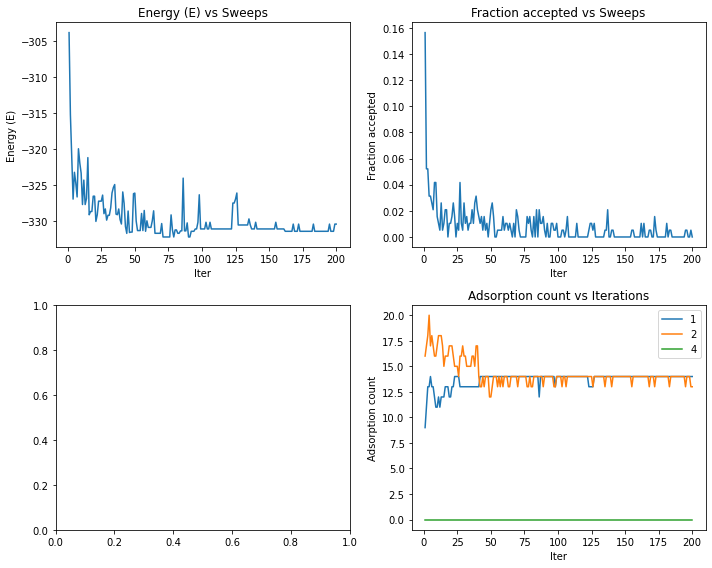

In [11]:
import matplotlib.pyplot as plt
runs = range(1, num_runs+1)
# do the plots
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(runs, energy_hist)
ax[0, 0].set_xlabel("Iter")
ax[0, 0].set_ylabel("Energy (E)")
ax[0, 0].set_title("Energy (E) vs Sweeps")

ax[0, 1].plot(runs, frac_accept_hist)
ax[0, 1].set_xlabel("Iter")
ax[0, 1].set_ylabel("Fraction accepted")
ax[0, 1].set_title("Fraction accepted vs Sweeps")

ax[1, 1].plot(runs, np.array(list(adsorption_count_hist.values())).T)
ax[1, 1].set_xlabel("Iter")
ax[1, 1].set_ylabel("Adsorption count")
ax[1, 1].legend(adsorption_count_hist.keys())
ax[1, 1].set_title("Adsorption count vs Iterations")

fig.show()
fig.tight_layout()

Coarse grain work

In [ ]:
from time import perf_counter

chem_pots = np.linspace(-4.0, 4.0, 9)
# chem_pots = [0] # do just one
num_runs = 100
all_energy_hist = np.random.rand(len(chem_pots), num_runs)
all_frac_accept_hist = np.random.rand(len(chem_pots), num_runs)
all_top_count_hist = np.random.rand(len(chem_pots), num_runs)
all_bridge_count_hist = np.random.rand(len(chem_pots), num_runs)
all_hollow_count_hist = np.random.rand(len(chem_pots), num_runs)

for i, chem_pot in enumerate(chem_pots):
    start = perf_counter()
    # chem pot 0 to less complicate things
    # temp in terms of kbT
    # 0.9 alpha for 20 runs
    history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=num_runs, temp=1, pot=chem_pot, alpha=0.99, slab=None, calc='LAMMPS')
    stop = perf_counter()
    print(f"Time taken = {stop - start} seconds")
    all_energy_hist[i] = energy_hist
    all_frac_accept_hist[i] = frac_accept_hist
    all_top_count_hist[i] = adsorption_count_hist[1]
    all_bridge_count_hist[i] = adsorption_count_hist[2]
    all_hollow_count_hist[i] = adsorption_count_hist[4]

In [ ]:
import matplotlib.pyplot as plt
# do the plots
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
runs = np.arange(1, num_runs+1)
legends = [f"\mu={mu}" for mu in chem_pots]
ax[0].plot(runs, all_energy_hist.T)
ax[0].set_xlabel("Iter")
ax[0].set_ylabel("Energy (E)")
ax[0].set_title("Energy (E) vs Iterations")
ax[0].legend(legends)

ax[1].plot(runs, all_frac_accept_hist.T)
ax[1].set_xlabel("Iter")
ax[1].set_ylabel("Fraction accepted")
ax[1].set_title("Fraction accepted vs Iterations")
ax[1].legend(legends)

fig.show()
fig.tight_layout()
# fig.savefig("energy_per_spin")
# fig.savefig("sgmc_anneal_alpha_0.9_repeat1.png")

In [ ]:
import matplotlib.pyplot as plt

# do the plots
fig, ax = plt.subplots(3, 1, figsize=(10, 8))
runs = np.arange(1, num_runs+1)
legends = [f"\mu={mu}" for mu in chem_pots]

ax[0].plot(runs, all_top_count_hist.T)
ax[0].set_xlabel("Iter")
ax[0].set_ylabel("Adsorption count")
ax[0].set_title("Top adsorption count vs Iterations")
ax[0].legend(legends)

ax[1].plot(runs, all_bridge_count_hist.T)
ax[1].set_xlabel("Iter")
ax[1].set_ylabel("Adsorption count")
ax[1].set_title("Bridge adsorption count vs Iterations")
ax[1].legend(legends)

ax[2].plot(runs, all_hollow_count_hist.T)
ax[2].set_xlabel("Iter")
ax[2].set_ylabel("Adsorption count")
ax[2].set_title("Hollow adsorption count vs Iterations")
ax[2].legend(legends)

fig.show()
fig.tight_layout()

Fine grain work

In [ ]:
from time import perf_counter

chem_pots = np.linspace(-3.125, -2.75, 5)
# chem_pots = [0] # do just one
num_runs = 500
all_energy_hist = np.random.rand(len(chem_pots), num_runs)
all_frac_accept_hist = np.random.rand(len(chem_pots), num_runs)
all_top_count_hist = np.random.rand(len(chem_pots), num_runs)
all_bridge_count_hist = np.random.rand(len(chem_pots), num_runs)
all_hollow_count_hist = np.random.rand(len(chem_pots), num_runs)

# use LAMMPS
parameters = {
    'pair_style': 'eam',
    'pair_coeff': ['* * Cu_u3.eam']
}
potential_file = os.path.join(os.environ["LAMMPS_POTENTIALS"], 'Cu_u3.eam')
lammps_calc = LAMMPS(files=[potential_file], keep_tmp_files=False, keep_alive=True, tmp_dir="/home/dux/surface_sampling/tmp_files")
lammps_calc.set(**parameters)

for i, chem_pot in enumerate(chem_pots):
    start = perf_counter()
    # chem pot 0 to less complicate things
    # temp in terms of kbT
    # 0.9 alpha for 20 runs
    history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=num_runs, temp=1, pot=chem_pot, alpha=0.99, slab=None, calc=lammps_calc)
    stop = perf_counter()
    print(f"Time taken = {stop - start} seconds")
    all_energy_hist[i] = energy_hist
    all_frac_accept_hist[i] = frac_accept_hist
    all_top_count_hist[i] = adsorption_count_hist[1]
    all_bridge_count_hist[i] = adsorption_count_hist[2]
    all_hollow_count_hist[i] = adsorption_count_hist[4]

In [ ]:
import matplotlib.pyplot as plt
# do the plots
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
runs = np.arange(1, num_runs+1)
legends = [f"\mu={mu}" for mu in chem_pots]
ax[0].plot(runs, all_energy_hist.T)
ax[0].set_xlabel("Iter")
ax[0].set_ylabel("Energy (E)")
ax[0].set_title("Energy (E) vs Iterations")
ax[0].legend(legends)

ax[1].plot(runs, all_frac_accept_hist.T)
ax[1].set_xlabel("Iter")
ax[1].set_ylabel("Fraction accepted")
ax[1].set_title("Fraction accepted vs Iterations")
ax[1].legend(legends)

fig.show()
fig.tight_layout()
# fig.savefig("energy_per_spin")
# fig.savefig("sgmc_anneal_alpha_0.9_repeat1.png")

In [ ]:
import matplotlib.pyplot as plt

# do the plots
fig, ax = plt.subplots(3, 1, figsize=(10, 8))
runs = np.arange(1, num_runs+1)
legends = [f"\mu={mu}" for mu in chem_pots]

ax[0].plot(runs, all_top_count_hist.T)
ax[0].set_xlabel("Iter")
ax[0].set_ylabel("Adsorption count")
ax[0].set_title("Top adsorption count vs Iterations")
ax[0].legend(legends)

ax[1].plot(runs, all_bridge_count_hist.T)
ax[1].set_xlabel("Iter")
ax[1].set_ylabel("Adsorption count")
ax[1].set_title("Bridge adsorption count vs Iterations")
ax[1].legend(legends)

ax[2].plot(runs, all_hollow_count_hist.T)
ax[2].set_xlabel("Iter")
ax[2].set_ylabel("Adsorption count")
ax[2].set_title("Hollow adsorption count vs Iterations")
ax[2].legend(legends)

fig.show()
fig.tight_layout()